## Uber Supply Demand Gap Analysis

### Data Loading and Cleanup

In [225]:
#Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [226]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Load the uber request data

In [227]:

uberData = pd.read_csv('Uber Request Data.csv')
uberData.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [228]:
# size of the dataframe
print('Data Size is - ' + str(uberData.shape))

Data Size is - (6745, 6)


In [229]:
# Let's first check the data for null values
# OBSERVATION 1
uberData.isna().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [230]:
# The non availability of (null value) Drop Timestamp may indicate 
# the trip was not started or cancelled
# Let's check
uberDataNoDropTime = uberData[uberData['Drop timestamp'].isna()]
uberDataNoDropTime.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
2831,2905,City,1.0,Cancelled,13-07-2016 06:08:41,NaN
2832,4805,City,1.0,Cancelled,14-07-2016 17:07:58,NaN
2833,5202,Airport,1.0,Cancelled,14-07-2016 20:51:37,NaN
2834,5927,City,1.0,Cancelled,15-07-2016 10:12:40,NaN
2835,2347,Airport,2.0,Cancelled,12/7/2016 19:14,NaN


In [231]:
uberDataNoDropTime['Status'].unique()

array(['Cancelled', 'No Cars Available'], dtype=object)

##### Above observations makes it clear that there is no need to drop columns with Drop timestamp NaN
##### Since Cancelled or 'No Cars Avaialable' requests will not have a drop timestamp
##### Drop timestamp column has proper data

In [232]:
# Let's check driver id column based on the OBSERVATION 1
uberDataNoDriverId = uberData[uberData['Driver id'].isna()]
uberDataNoDriverId.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
4095,1362,City,NaN,No Cars Available,11/7/2016 0:02,NaN
4096,1364,City,NaN,No Cars Available,11/7/2016 0:06,NaN
4097,1366,City,NaN,No Cars Available,11/7/2016 0:09,NaN
4098,2,Airport,NaN,No Cars Available,11/7/2016 0:23,NaN
4099,7,Airport,NaN,No Cars Available,11/7/2016 0:30,NaN


In [233]:
uberDataNoDriverId['Status'].unique()

array(['No Cars Available'], dtype=object)

##### Above observations makes it clear that there is no need to drop columns with Driver id NaN
##### Since 'No Cars Avaialable' requests will not have a Driver Id
##### Driver id column has proper data

In [234]:
# check the data type of the timestamp columns
uberData.dtypes

Request id             int64
Pickup point          object
Driver id            float64
Status                object
Request timestamp     object
Drop timestamp        object
dtype: object

In [235]:
#we nedd to correct the data type of the timestamp columns
uberData['Request timestamp'] = pd.to_datetime(uberData['Request timestamp'])
uberData['Drop timestamp'] = pd.to_datetime(uberData['Drop timestamp'])

In [236]:
# check again the data type of the timestamp columns
print(uberData.dtypes)
uberData.head()

Request id                    int64
Pickup point                 object
Driver id                   float64
Status                       object
Request timestamp    datetime64[ns]
Drop timestamp       datetime64[ns]
dtype: object


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


#### -----------------------------------------------------------------------------------
### Univariate Analysis

In [237]:
# Let's define a function to plot the graphs
def showSNSCountPlot(df, title, catField, hue_var, color, fig_size_x, fig_size_y,x_label_rotation,y_label_rotation) :
    plt.figure(figsize=(fig_size_x, fig_size_y))
    plt.title(title)
    sns_cnt_plot = sns.countplot(data= df, x = df[catField], hue=hue_var, palette=color)

    for p in sns_cnt_plot.patches:
        sns_cnt_plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                              p.get_height()), 
                              ha = 'center', va = 'center', xytext = (0, 10), 
                              textcoords = 'offset points')
    plt.xticks(rotation=x_label_rotation)
    plt.yticks(rotation=y_label_rotation)
    plt.show()

##### Let's check trip types based on the pickup point


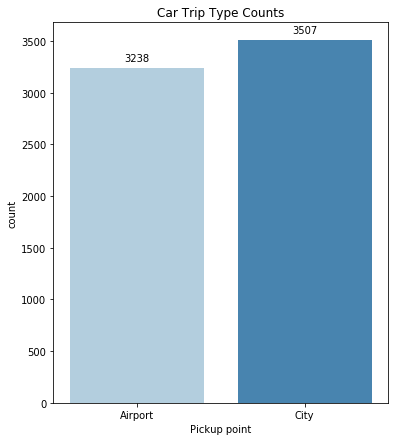

In [238]:
showSNSCountPlot(uberData, 'Car Trip Type Counts', 'Pickup point', None, 'Blues', 6, 7,0,0)

##### Car Status Count

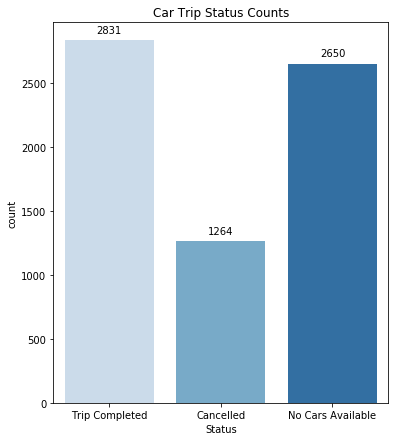

In [239]:
showSNSCountPlot(uberData,'Car Trip Status Counts','Status',None,'Blues',6,7,0,0)


##### There are 2650 requests with status 'No Cars Avaialble' and 1264 requests with status 'Cancelled'. This is huge revenue loss for the company

### -----------------------------------------------------------
### Bivariate Analysis

##### Let's check how much of these status are contributing towards each trip types

In [240]:
#group by data with Status and pickup point
uberCatData = uberData.groupby(['Status', 'Pickup point']).size()
print(uberCatData)

Status             Pickup point
Cancelled          Airport          198
                   City            1066
No Cars Available  Airport         1713
                   City             937
Trip Completed     Airport         1327
                   City            1504
dtype: int64


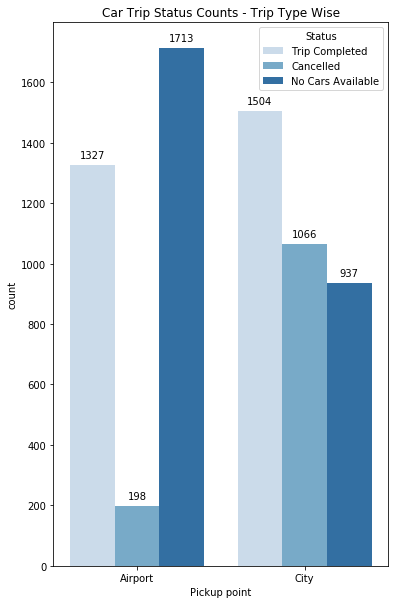

In [241]:
# plot the status of the trip request based on trip type
showSNSCountPlot(uberData,'Car Trip Status Counts - Trip Type Wise','Pickup point',
                 uberData['Status'],'Blues',6,10,0,0)


##### For City to Airport trips there are more requests that fall in the No Cars Available status while for Airport to City trips has problem of both Trip Cancelled and No Cars Available types

### Indentify more matrics

In [242]:
# define function to add demand and supply Gap column
def addSupplyDemandGap(df) :
    df['Gap'] = 'Trip Not Completed' # default value for all rows
    df.loc[df['Status'] == 'Trip Completed', 'Gap'] = 'Trip Completed'   

In [243]:
# add demand gap
addSupplyDemandGap(uberData)

#check data
uberData.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Gap
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Trip Completed
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Trip Completed
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Trip Completed
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Trip Completed
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Trip Completed


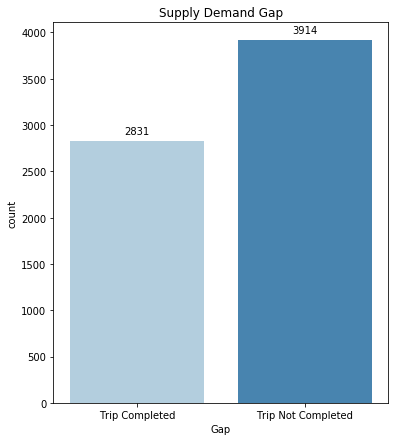

In [244]:
showSNSCountPlot(uberData, 'Supply Demand Gap', 'Gap', None, 'Blues', 6, 7, 0, 0)

In [245]:
# define function that will add one more column to identify Day Parting (Morning, Late Morning, Noon, Evening, Night)

def addDayParting(df,timestampColumn, columnName) :
    
    #hour of the day
    df['Request Day Hour'] = df[timestampColumn].dt.hour
    
    #identify day parting based on day hour
    df[columnName] = 'Early Morning'
    df.loc[df['Request Day Hour'].between(5,8, inclusive=True),columnName] = 'Morning'
    df.loc[df['Request Day Hour'].between(9,12, inclusive=True),columnName] = 'Late Morning'
    df.loc[df['Request Day Hour'].between(13,16, inclusive=True),columnName] = 'Noon'
    df.loc[df['Request Day Hour'].between(17,21, inclusive=True),columnName] = 'Evening'
    df.loc[df['Request Day Hour'].between(21,24, inclusive=True),columnName] = 'Night'
    
    

In [246]:
# add day time
addDayParting(uberData,'Request timestamp','Request Time Slot')

# check the data
uberData.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Gap,Request Day Hour,Request Time Slot
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Trip Completed,11,Late Morning
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Trip Completed,17,Evening
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Trip Completed,9,Late Morning
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Trip Completed,21,Night
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Trip Completed,8,Morning


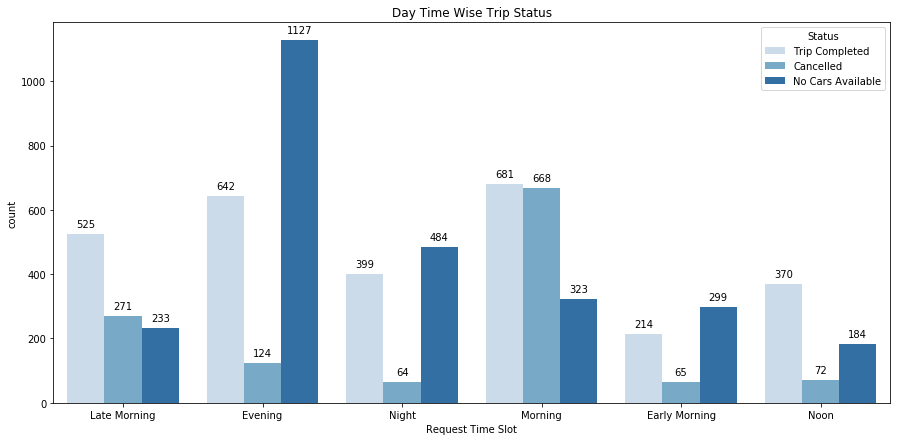

In [247]:
#plot the above data

showSNSCountPlot(uberData, 'Day Time Wise Trip Status', 'Request Time Slot', uberData['Status'], 'Blues', 15, 7, 0, 0)

#### Most of the 'No Cars Available' Cases are in the evening
#### Most of the 'Cancelled' cases are in the morning

### Check how this is impacted by the Trip Type viz Airport, City


In [248]:
# add one more column combining the Pickup Point and Time Slow
uberData['pickup_time_slot'] = uberData['Pickup point'] + '_' + uberData['Request Time Slot']
uberData.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Gap,Request Day Hour,Request Time Slot,pickup_time_slot
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Trip Completed,11,Late Morning,Airport_Late Morning
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Trip Completed,17,Evening,Airport_Evening
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Trip Completed,9,Late Morning,City_Late Morning
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Trip Completed,21,Night,Airport_Night
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Trip Completed,8,Morning,City_Morning


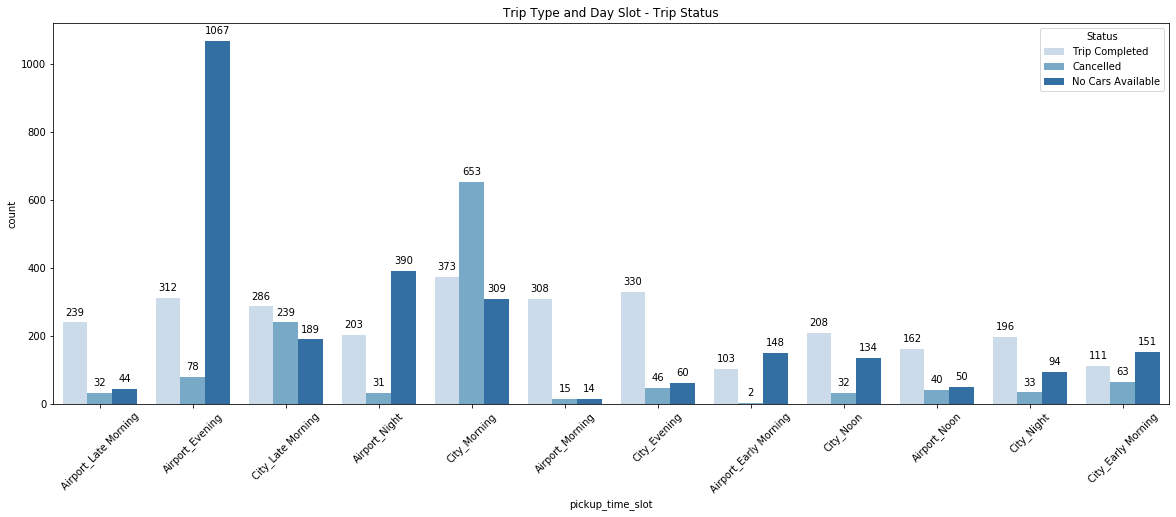

In [249]:
#plot the above data

showSNSCountPlot(uberData, 'Trip Type and Day Slot - Trip Status', 'pickup_time_slot', uberData['Status'], 'Blues', 
                 20, 7, 45, 0)

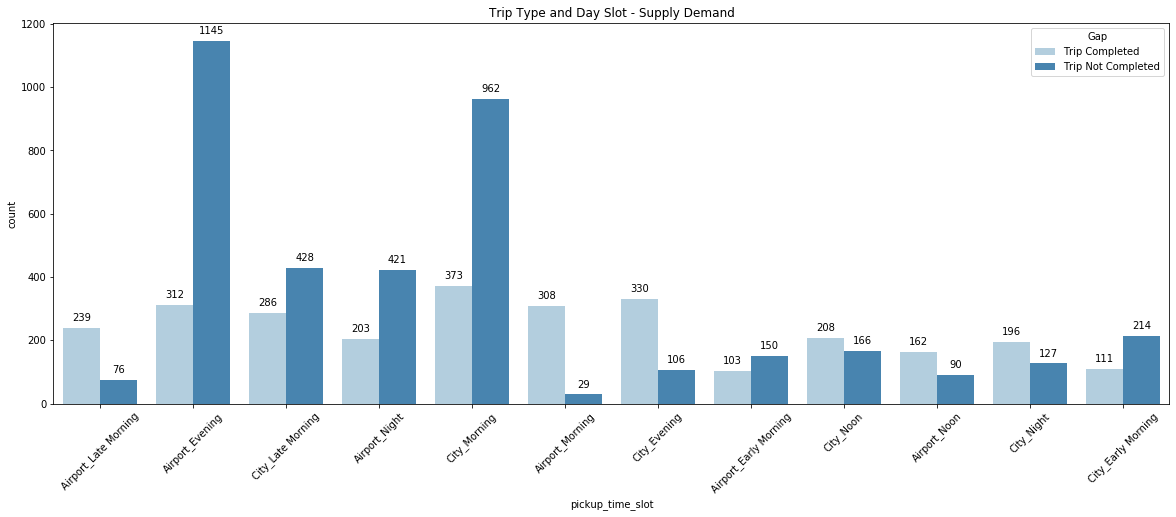

In [250]:
#plot the above data

showSNSCountPlot(uberData, 'Trip Type and Day Slot - Supply Demand', 'pickup_time_slot', uberData['Gap'], 'Blues', 
                 20, 7, 45, 0)

#### There is a huge demand supply gap in the evening from airport to city

#### check day time slot wise supply demand gap

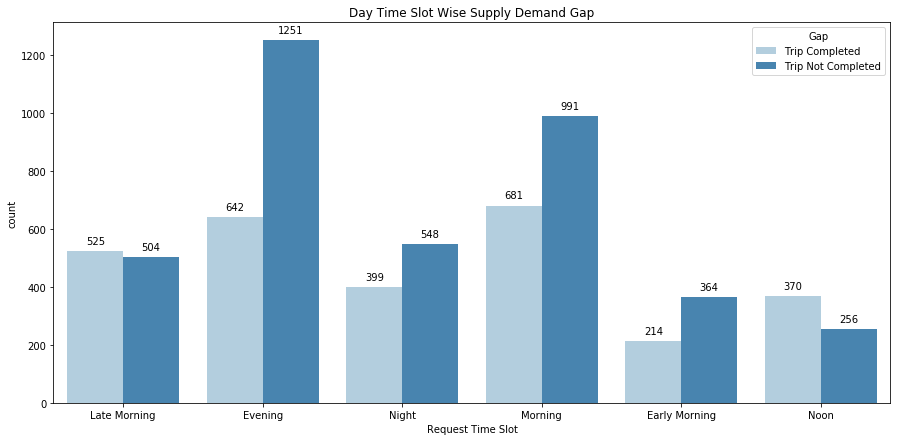

In [251]:
#plot Gap per slot

showSNSCountPlot(uberData, 'Day Time Slot Wise Supply Demand Gap', 'Request Time Slot', uberData['Gap'], 'Blues', 
                 15, 7, 0, 0)

#### There is more supply demand gap in the evening and morning

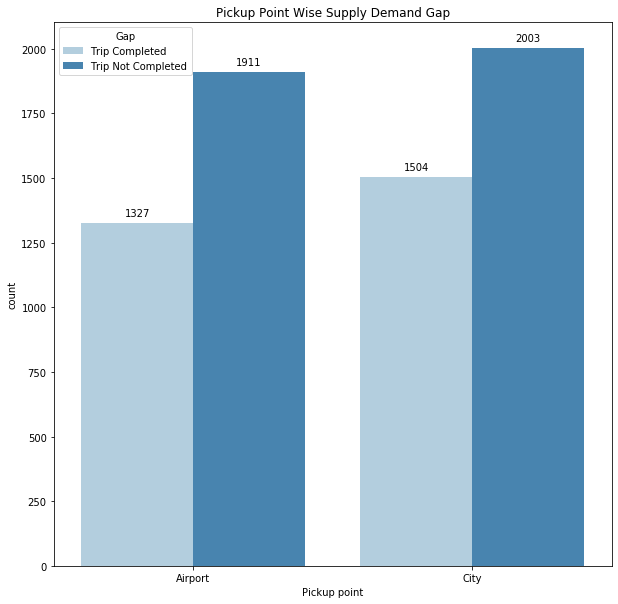

In [252]:
#### check trip type supply deman gap
showSNSCountPlot(uberData, 'Pickup Point Wise Supply Demand Gap', 'Pickup point', uberData['Gap'], 'Blues', 
                 10, 10,0,0)

## Hypothesis
### City Pickup points - 
    - It is observed that due to high demand in the morning there are more cancellation of the trip requests. Driver may want to earn more in the city with many trips than a single long trip to the Airport
    
### Airport Pickup points - 
    - It is obeserved that in the evening there are more issues related to cars not being available for airport pickup points. The drivers are busy serving within the city during this time

## Reccomendations
### City Pickup points
    - There is high demand for the rides in the early morning and drivers are choosing to complete more trips withing city than the long trip to airport. Drivers should be incentivized to take airport trips in the morning slots so that they will not cancel airport trip requests in early morning.
### Airport Pickup points
    - There are no cabs in the airport in the evening times since most of the cabs are busy serving within the city completing the trips. We should incentivize the drivers to take evening airport to city trips. This may cause lots of cabs near the airport in waiting for the trip request. We should also provide some permanent parking near the airport for cabs waiting
    
    - It is also recommended to increase the overall cab fleet size

-------------------------------------- Completed -------------------------------------